```https://github.com/quantopian/qgrid

In [1]:
import pandas as pd
import numpy as np
import os
import scipy
import itertools
#os.environ['XGBOOST_BUILD_DOC'] = 'C:\\Users\\sushant\\Anaconda2\\lib\\site-packages\\xgboost;'
import matplotlib.pyplot as plt    
import xgboost as xgb
iv=['np'	, 'os'	 ,'pd'	, 'plt'	 ,'tqdm'	, 'train'	 ,'train_date'	, 'train_date_num'	, 'train_num'	 ]
def memchk(iv):
    import sys,operator
    ipython_vars=iv
    ,'warnings'	, 'xgboost']
    print sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
    return sorted([{i:sys.getsizeof(globals().get(i))/1000000.0} for i in ipython_vars])
%matplotlib inline
from sklearn.metrics import confusion_matrix
import warnings
%load_ext autotime
warnings.filterwarnings('ignore')
from tqdm import tqdm

C:\Users\sushant\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


time: 31 ms


### Importing list of selected Features

In [3]:
feat6 = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Results\\impFeat_sample_bal6.csv')#,usecols=['fea','coef'])
feat7 = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Results\\impFeat_sample_bal7.csv')#,usecols=['fea','coef']).rename(columns={'coef':'coef2'})
feat8 = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Results\\impFeat_sample_bal8.csv')#,usecols=['fea','coef']).rename(columns={'coef':'coef3'})

feat6=feat6[feat6['coef']>0]
feat7=feat7[feat7['coef']>0]
feat8=feat8[feat8['coef']>0]

time: 115 ms


In [4]:
feats = feat6.merge(feat7.merge(feat8,on='fea',how='inner'),on='fea',how='inner')

time: 58 ms


In [5]:
#feats.fea

time: 64 ms


In [6]:
feats['FFlag']=feats['FeatureNo'].apply(lambda l: l[0])
feats.head()

,fea,coef,LineNo,StationNo,FeatureNo,coef_x,LineNo_x,StationNo_x,FeatureNo_x,coef_y,LineNo_y,StationNo_y,FeatureNo_y,FFlag
0,L3_S33_F3857,0.015941,L3,S33,F3857,0.011501,L3,S33,F3857,0.006732,L3,S33,F3857,F
1,L3_S33_F3859,0.015014,L3,S33,F3859,0.009486,L3,S33,F3859,0.011613,L3,S33,F3859,F
2,L3_S30_F3519,0.013160,L3,S30,F3519,0.004656,L3,S30,F3519,0.004370,L3,S30,F3519,F
3,L3_S30_F3809,0.012790,L3,S30,F3809,0.005038,L3,S30,F3809,0.007440,L3,S30,F3809,F
4,L3_S29_F3315,0.011863,L3,S29,F3315,0.004969,L3,S29,F3315,0.004763,L3,S29,F3315,F


time: 92 ms


#### Separating numeric and date features

In [7]:
feat_num=feats[feats['FFlag']=='F']['fea'].tolist()+['Id','Unnamed: 0','Response']
feat_date=feats[feats['FFlag']=='D']['fea'].tolist()+['Id','Unnamed: 0']

time: 80 ms


In [8]:
del feats

time: 83 ms


### Load sample numeric and date

In [9]:
train_num = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Samples\\sample_num_bal6.csv',dtype=np.float32,usecols =feat_num).head(10000).set_index('Unnamed: 0')
#train_cat = pd.read_csv('sample_cat.csv').head().set_index('Unnamed: 0')
train_date = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Samples\\sample_date_bal6.csv',dtype=np.float32,usecols =feat_date).head(10000).set_index('Unnamed: 0')

time: 959 ms


In [10]:
train_num.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 9030 entries, 172.0 to 83722.0
Columns: 274 entries, Id to Response
dtypes: float32(274)
memory usage: 9.5 MB
time: 28 ms


In [11]:
#feat_num

time: 59 ms


In [12]:
train_date.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 9030 entries, 172.0 to 3722.0
Data columns (total 31 columns):
Id              9030 non-null float32
L0_S0_D1        4994 non-null float32
L0_S2_D34       2478 non-null float32
L0_S3_D70       2515 non-null float32
L0_S4_D106      2443 non-null float32
L0_S5_D115      2555 non-null float32
L0_S6_D120      2536 non-null float32
L0_S7_D137      2462 non-null float32
L0_S9_D152      1682 non-null float32
L0_S10_D216     1724 non-null float32
L0_S11_D280     1598 non-null float32
L0_S12_D331     1809 non-null float32
L0_S14_D360     926 non-null float32
L0_S15_D395     883 non-null float32
L0_S16_D423     913 non-null float32
L0_S18_D437     883 non-null float32
L0_S21_D469     643 non-null float32
L1_S24_D1511    1165 non-null float32
L1_S24_D1583    600 non-null float32
L1_S24_D1674    574 non-null float32
L2_S26_D3037    1873 non-null float32
L2_S27_D3130    973 non-null float32
L3_S29_D3316    8560 non-null float32
L3_S30_D3496    856

#### Empty Date frame

In [13]:
#train_date=train_num[['Id']]

time: 96 ms


In [14]:
pd.merge(train_num,train_date).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9030 entries, 0 to 9029
Columns: 304 entries, Id to L3_S49_D4208
dtypes: float32(304)
memory usage: 10.5 MB
time: 117 ms


#### Merge numeric and date sample

In [15]:
train_date_num=pd.merge(train_num,train_date)#.set_index(['Unnamed: 0_x'])

time: 55 ms


In [16]:
train_date_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9030 entries, 0 to 9029
Columns: 304 entries, Id to L3_S49_D4208
dtypes: float32(304)
memory usage: 10.5 MB
time: 69 ms


In [17]:
#train_date_num

time: 56 ms


In [18]:
train=train_date_num.copy()

time: 78 ms


In [19]:
memchk(iv)

[('iv', 136), ('ipython_vars', 16)]


[{'np': 4.8e-05},
 {'os': 4.8e-05},
 {'pd': 4.8e-05},
 {'plt': 4.8e-05},
 {'tqdm': 0.000896},
 {'train': 11.052744},
 {'train_date': 1.191984},
 {'train_date_num': 11.052744},
 {'train_num': 9.969144}]

time: 120 ms


In [20]:
del train_date_num

time: 31 ms


### Fill NA 

In [21]:
train=train[['Id','Response']].merge(train.drop(['Id','Response'],1).applymap(lambda l: l+2),left_index=True,right_index=True)

time: 749 ms


In [22]:
#train

time: 1 ms


In [23]:
#test_cat=pd.read_csv()

time: 107 ms


In [24]:
train.fillna(0, inplace=True) 

time: 81 ms


### Define predictor & target (X,y)

In [25]:
y=train[['Response']].reset_index(drop=True)

time: 77 ms


In [26]:
X=train.drop(['Id','Response'],1).reset_index(drop=True)

time: 82 ms


In [27]:
X.shape

(9030, 302)

time: 66 ms


In [28]:
y.shape

(9030, 1)

time: 76 ms


In [29]:
#y

time: 82 ms


### Create Model

In [30]:
#from xgboost import XGBClassifier 
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

time: 756 ms


In [32]:
#str(param_gr).replace("'","").replace(":","=")

time: 1e+03 µs


In [33]:
from sklearn.model_selection import GridSearchCV
param_gr  ={'max_depth':[5,15,30]
             , 
            'learning_rate':[0.1 ,0.05]
            ,
 'n_estimators':[500,200] 
,
'nthread':[5],
 
'base_score':[0.5 ,0.01]
 }

time: 5 ms


In [34]:
clf=XGBClassifier()

time: 2 ms


In [35]:
grid_search = GridSearchCV(clf, param_grid=param_gr ,scoring='accuracy')

time: 1 ms


```
if test_y is not None:
    xgtest = xgboost.DMatrix(test_X, label=test_y)
    watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
    model = xgboost.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
else:
    xgtest = xgboost.DMatrix(test_X)
    model = xgboost.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model
```

In [36]:
#clf=RandomForestClassifier(max_depth=10,n_estimators =200,class_weight ='balanced')

time: 2 ms


In [37]:
preds = np.ones(y.shape[0])

time: 2 ms


In [38]:
#cvs=cross_val_score(clf,X,y,cv=5,scoring='f1')

time: 1e+03 µs


In [39]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

time: 6 ms


In [40]:
iv=['np'	, 'os'	 ,'pd'	, 'plt'	 ,'tqdm'	, 'train'	 ,'train_date'	, 'train_date_num'	, 'train_num'	 ]+['DecisionTreeClassifier',	 'StratifiedKFold',	 'X',	 'XGBClassifier',	 'clf',	 'cross_val_score',	 'cvs',	 'matthews_corrcoef', 'y' ]
memchk(iv)

[('iv', 208), ('ipython_vars', 16)]


[{'DecisionTreeClassifier': 0.000896},
 {'StratifiedKFold': 0.000896},
 {'X': 21.816576},
 {'XGBClassifier': 0.000896},
 {'clf': 5.6e-05},
 {'cross_val_score': 0.000112},
 {'cvs': 1.6e-05},
 {'matthews_corrcoef': 0.000112},
 {'np': 4.8e-05},
 {'os': 4.8e-05},
 {'pd': 4.8e-05},
 {'plt': 4.8e-05},
 {'tqdm': 0.000896},
 {'train': 21.960984},
 {'train_date': 1.191984},
 {'train_date_num': 1.6e-05},
 {'train_num': 9.969144},
 {'y': 0.036216}]

time: 70 ms


#### Fit training data

In [41]:
grid_search.fit(X,y['Response'])

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500, 200], 'learning_rate': [0.1, 0.05], 'max_depth': [5, 15, 30], 'base_score': [0.5, 0.01], 'nthread': [5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

time: 30min 49s


In [42]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.718 (std: 0.008)
Parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5, 'base_score': 0.5, 'nthread': 5}

Model with rank: 2
Mean validation score: 0.717 (std: 0.008)
Parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 30, 'base_score': 0.5, 'nthread': 5}

Model with rank: 3
Mean validation score: 0.716 (std: 0.007)
Parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 30, 'base_score': 0.5, 'nthread': 5}

Model with rank: 4
Mean validation score: 0.716 (std: 0.008)
Parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 15, 'base_score': 0.5, 'nthread': 5}

Model with rank: 5
Mean validation score: 0.715 (std: 0.004)
Parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5, 'base_score': 0.01, 'nthread': 5}

time: 55 ms


In [43]:
clf=XGBClassifier(n_estimators= 200, learning_rate= 0.05, max_depth= 5, base_score= 0.5, nthread= 5)
clf.fit(X,y['Response'])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=200, nthread=5,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

time: 7.85 s


In [44]:
memchk(iv)

[('iv', 208), ('ipython_vars', 16)]


[{'DecisionTreeClassifier': 0.000896},
 {'StratifiedKFold': 0.000896},
 {'X': 21.816576},
 {'XGBClassifier': 0.000896},
 {'clf': 5.6e-05},
 {'cross_val_score': 0.000112},
 {'cvs': 1.6e-05},
 {'matthews_corrcoef': 0.000112},
 {'np': 4.8e-05},
 {'os': 4.8e-05},
 {'pd': 4.8e-05},
 {'plt': 4.8e-05},
 {'tqdm': 0.000896},
 {'train': 21.960984},
 {'train_date': 1.191984},
 {'train_date_num': 1.6e-05},
 {'train_num': 9.969144},
 {'y': 0.036216}]

time: 32 ms


```for i, (train, test) in enumerate(cv):
    print X[train]
    #print clf.fit(X[train], y[train]).predict_proba(X[test])
   ```

'''for i, (train, test) in enumerate(cv):
    preds[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], preds[test])))
print(roc_auc_score(y, preds))

## Load test Data sample

In [45]:
test_num = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Samples\\sample_num1.csv',dtype=np.float32,usecols =feat_num).head(10000).set_index('Unnamed: 0')
#train_cat = pd.read_csv('sample_cat.csv').head().set_index('Unnamed: 0')
test_date = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Samples\\sample_date1.csv',dtype=np.float32,usecols =feat_date).head(10000).set_index('Unnamed: 0')

time: 946 ms


In [46]:
test_num.info(),test_date.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10000 entries, 114.0 to 82226.0
Columns: 274 entries, Id to Response
dtypes: float32(274)
memory usage: 10.5 MB
<class 'pandas.core.frame.DataFrame'>
Float64Index: 10000 entries, 114.0 to 2226.0
Data columns (total 31 columns):
Id              10000 non-null float32
L0_S0_D1        5791 non-null float32
L0_S2_D34       2916 non-null float32
L0_S3_D70       2877 non-null float32
L0_S4_D106      2844 non-null float32
L0_S5_D115      2951 non-null float32
L0_S6_D120      2921 non-null float32
L0_S7_D137      2875 non-null float32
L0_S9_D152      1899 non-null float32
L0_S10_D216     1923 non-null float32
L0_S11_D280     1977 non-null float32
L0_S12_D331     2045 non-null float32
L0_S14_D360     1035 non-null float32
L0_S15_D395     1011 non-null float32
L0_S16_D423     1037 non-null float32
L0_S18_D437     1009 non-null float32
L0_S21_D469     699 non-null float32
L1_S24_D1511    1078 non-null float32
L1_S24_D1583    518 non-null float32

(None, None)

time: 40 ms


#### Fill NA

In [47]:
test_date.head()

,Id,L0_S0_D1,L0_S2_D34,L0_S3_D70,L0_S4_D106,L0_S5_D115,L0_S6_D120,L0_S7_D137,L0_S9_D152,L0_S10_D216,...,L2_S27_D3130,L3_S29_D3316,L3_S30_D3496,L3_S32_D3852,L3_S33_D3856,L3_S34_D3875,L3_S35_D3886,L3_S36_D3919,L3_S39_D3966,L3_S49_D4208
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
114.0,245.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1407.939941,1407.939941,NaN,1407.949951,1407.959961,1407.959961,NaN,NaN,NaN
166.0,337.0,1115.180054,1115.180054,NaN,NaN,1115.199951,NaN,1115.209961,NaN,NaN,...,NaN,1121.869995,1121.880005,NaN,1121.890015,1121.890015,NaN,1121.890015,NaN,NaN
343.0,669.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1160.510010,1160.510010,NaN,1160.560059,1160.560059,1160.560059,NaN,NaN,NaN
462.0,902.0,1245.770020,NaN,1245.77002,1245.790039,NaN,NaN,1245.800049,NaN,NaN,...,1289.869995,1294.459961,1294.469971,NaN,1294.479980,1294.479980,NaN,1294.489990,NaN,NaN
468.0,909.0,1226.229980,1226.239990,NaN,1226.250000,NaN,NaN,1226.260010,1226.26001,NaN,...,NaN,1238.160034,1238.170044,NaN,1238.189941,1238.189941,1238.189941,NaN,NaN,NaN


time: 59 ms


In [48]:
pd.merge(test_num,test_date).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Columns: 304 entries, Id to L3_S49_D4208
dtypes: float32(304)
memory usage: 11.7 MB
time: 60 ms


#### Empty frame  test date

In [49]:
#test_date=test_num[['Id']]

time: 1e+03 µs


#### Merging numeric & date test sample

In [50]:
test_date_num=pd.merge(test_num,test_date)

time: 19 ms


In [51]:
test_date_num=test_date_num[['Id','Response']].merge(test_date_num.drop(['Id','Response'],1).applymap(lambda l: l+2),left_index=True,right_index=True)

test_date_num.fillna(0, inplace=True) 

time: 779 ms


In [52]:
test_date_num=test_date_num.drop_duplicates()

time: 195 ms


In [55]:
y['Response'].value_counts(),y1['Response'].value_counts()

(0.0    5987
 1.0    3043
 Name: Response, dtype: int64, 0.0    9942
 1.0      58
 Name: Response, dtype: int64)

time: 8 ms


In [56]:
X.info(),X1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9030 entries, 0 to 9029
Columns: 302 entries, L0_S0_F0 to L3_S49_D4208
dtypes: float64(302)
memory usage: 20.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 302 entries, L0_S0_F0 to L3_S49_D4208
dtypes: float64(302)
memory usage: 23.0 MB


(None, None)

time: 26 ms


#### Define test predictor and target

In [54]:
y1=test_date_num[['Response']].reset_index(drop=True)
X1=test_date_num.drop(['Id','Response'],1).reset_index(drop=True)

time: 29 ms


In [57]:
#z,clf = runXGB(X,y,X1,y1,X.columns.tolist(),0,300)

NameError: name 'runXGB' is not defined

time: 15 ms


#### Predicting test sample

In [59]:
len(y1),len(X1),len(X),len(y),

(10000, 10000, 9030, 9030)

time: 4 ms


In [60]:
z =clf.predict(X1)

time: 133 ms


In [61]:
z

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

time: 4 ms


In [62]:
z=np.round(z)

time: 1e+03 µs


In [63]:

#out=pd.DataFrame(z)
#out['Class']=out[0].apply( lambda l: np.round(l))

time: 1e+03 µs


### Analyzing Result

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
cnf_matrix = confusion_matrix(y1, z)

time: 53 ms


Confusion matrix, without normalization
[[9667  275]
 [  47   11]]


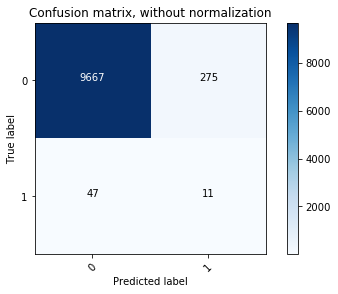

time: 432 ms


In [65]:
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

In [66]:
print classification_report(y1,z)

             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98      9942
        1.0       0.04      0.19      0.06        58

avg / total       0.99      0.97      0.98     10000

time: 10 ms


0.073802271417


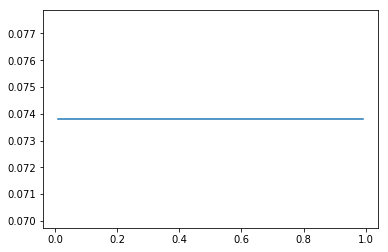

time: 278 ms


In [67]:
from sklearn.metrics import matthews_corrcoef, roc_auc_score
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y1, z>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [68]:
matthews_corrcoef(y1, z)

0.073802271416958706

time: 7 ms


In [69]:
feat_date.remove('Unnamed: 0')
feat_num.remove('Unnamed: 0')


time: 1e+03 µs


In [70]:
feat_date.remove('Response')



ValueError: list.remove(x): x not in list

time: 16 ms


In [71]:
feat_num.remove('Response')

time: 1e+03 µs


In [72]:
set(test_num.columns.tolist())-set(feat_num)

{'Response'}

time: 3 ms


In [73]:
set(feat_num)-set(test_num.columns.tolist())

set()

time: 3 ms


## Read Test 

In [82]:
test_num=pd.read_csv('test_numeric.csv.zip',compression='zip',chunksize=500, usecols=feat_num)
test_date=pd.read_csv('test_date.csv.zip',compression='zip',chunksize=500, usecols=feat_date)

time: 292 ms


## Pred Test

In [83]:
test_pred_res=pd.DataFrame()
for chunk1,chunk2 in tqdm(zip(test_num,test_date)): 
    test_date_num=pd.merge(chunk1,chunk2,on='Id')#.drop('Id',1)
    test_date_num=test_date_num[['Id']].merge(test_date_num.drop('Id',1).applymap(lambda l: l+2),left_index=True,right_index=True)
    test_date_num=test_date_num.fillna(0) 
    testpr=test_date_num[['Id']]
    testpr['Response']=clf.predict(test_date_num.drop('Id',1))
    test_pred_res=test_pred_res.append(testpr)
    del testpr
    del test_date_num




  0%|                                                                                         | 0/2368 [00:00<?, ?it/s]

  0%|                                                                               | 1/2368 [00:02<1:29:11,  2.26s/it]

  0%|                                                                               | 2/2368 [00:02<1:08:19,  1.73s/it]

  0%|                                                                                 | 3/2368 [00:03<55:27,  1.41s/it]

  0%|▏                                                                                | 4/2368 [00:04<45:51,  1.16s/it]

  0%|▏                                                                                | 5/2368 [00:04<38:52,  1.01it/s]

  0%|▏                                                                                | 6/2368 [00:04<31:18,  1.26it/s]

  0%|▏                                                                                | 7/2368 [00:05<28:04,  1.40it/s]

  0%|▎                        

  3%|██▎                                                                             | 67/2368 [00:32<12:36,  3.04it/s]

  3%|██▎                                                                             | 68/2368 [00:32<12:52,  2.98it/s]

  3%|██▎                                                                             | 69/2368 [00:32<13:25,  2.85it/s]

  3%|██▎                                                                             | 70/2368 [00:33<13:28,  2.84it/s]

  3%|██▍                                                                             | 71/2368 [00:33<13:03,  2.93it/s]

  3%|██▍                                                                             | 72/2368 [00:33<12:56,  2.96it/s]

  3%|██▍                                                                             | 73/2368 [00:34<12:56,  2.96it/s]

  3%|██▌                                                                             | 74/2368 [00:34<13:37,  2.81it/s]

  3%|██▌                        

  6%|████▍                                                                          | 134/2368 [00:53<10:45,  3.46it/s]

  6%|████▌                                                                          | 135/2368 [00:53<10:42,  3.48it/s]

  6%|████▌                                                                          | 136/2368 [00:53<10:55,  3.41it/s]

  6%|████▌                                                                          | 137/2368 [00:54<10:57,  3.39it/s]

  6%|████▌                                                                          | 138/2368 [00:54<11:08,  3.33it/s]

  6%|████▋                                                                          | 139/2368 [00:54<10:47,  3.44it/s]

  6%|████▋                                                                          | 140/2368 [00:54<10:28,  3.55it/s]

  6%|████▋                                                                          | 141/2368 [00:55<10:10,  3.65it/s]

  6%|████▋                      

  8%|██████▋                                                                        | 201/2368 [01:19<11:58,  3.01it/s]

  9%|██████▋                                                                        | 202/2368 [01:20<12:09,  2.97it/s]

  9%|██████▊                                                                        | 203/2368 [01:20<12:50,  2.81it/s]

  9%|██████▊                                                                        | 204/2368 [01:20<12:37,  2.86it/s]

  9%|██████▊                                                                        | 205/2368 [01:21<11:31,  3.13it/s]

  9%|██████▊                                                                        | 206/2368 [01:25<54:09,  1.50s/it]

  9%|██████▉                                                                        | 207/2368 [01:26<45:36,  1.27s/it]

  9%|██████▉                                                                        | 208/2368 [01:26<36:56,  1.03s/it]

  9%|██████▉                    

 11%|████████▉                                                                      | 268/2368 [01:46<09:34,  3.66it/s]

 11%|████████▉                                                                      | 269/2368 [01:47<09:11,  3.81it/s]

 11%|█████████                                                                      | 270/2368 [01:47<09:01,  3.88it/s]

 11%|█████████                                                                      | 271/2368 [01:47<08:57,  3.90it/s]

 11%|█████████                                                                      | 272/2368 [01:47<09:01,  3.87it/s]

 12%|█████████                                                                      | 273/2368 [01:48<08:58,  3.89it/s]

 12%|█████████▏                                                                     | 274/2368 [01:48<08:42,  4.01it/s]

 12%|█████████▏                                                                     | 275/2368 [01:48<08:20,  4.18it/s]

 12%|█████████▏                 

 14%|███████████▏                                                                   | 335/2368 [02:05<10:53,  3.11it/s]

 14%|███████████▏                                                                   | 336/2368 [02:06<11:17,  3.00it/s]

 14%|███████████▏                                                                   | 337/2368 [02:06<14:30,  2.33it/s]

 14%|███████████▎                                                                   | 338/2368 [02:07<13:31,  2.50it/s]

 14%|███████████▎                                                                   | 339/2368 [02:07<13:08,  2.57it/s]

 14%|███████████▎                                                                   | 340/2368 [02:07<11:55,  2.84it/s]

 14%|███████████▍                                                                   | 341/2368 [02:08<12:33,  2.69it/s]

 14%|███████████▍                                                                   | 342/2368 [02:08<13:41,  2.47it/s]

 14%|███████████▍               

 17%|█████████████▍                                                                 | 402/2368 [02:31<10:12,  3.21it/s]

 17%|█████████████▍                                                                 | 403/2368 [02:31<10:35,  3.09it/s]

 17%|█████████████▍                                                                 | 404/2368 [02:31<10:54,  3.00it/s]

 17%|█████████████▌                                                                 | 405/2368 [02:32<10:25,  3.14it/s]

 17%|█████████████▌                                                                 | 406/2368 [02:32<09:46,  3.35it/s]

 17%|█████████████▌                                                                 | 407/2368 [02:32<09:46,  3.34it/s]

 17%|█████████████▌                                                                 | 408/2368 [02:32<09:25,  3.47it/s]

 17%|█████████████▋                                                                 | 409/2368 [02:33<09:04,  3.60it/s]

 17%|█████████████▋             

 20%|███████████████▋                                                               | 469/2368 [02:55<10:14,  3.09it/s]

 20%|███████████████▋                                                               | 470/2368 [02:56<10:30,  3.01it/s]

 20%|███████████████▋                                                               | 471/2368 [02:56<10:36,  2.98it/s]

 20%|███████████████▋                                                               | 472/2368 [02:56<09:57,  3.17it/s]

 20%|███████████████▊                                                               | 473/2368 [02:57<10:02,  3.15it/s]

 20%|███████████████▊                                                               | 474/2368 [02:57<09:35,  3.29it/s]

 20%|███████████████▊                                                               | 475/2368 [02:57<09:15,  3.41it/s]

 20%|███████████████▉                                                               | 476/2368 [02:57<08:57,  3.52it/s]

 20%|███████████████▉           

 23%|█████████████████▉                                                             | 536/2368 [03:17<08:28,  3.60it/s]

 23%|█████████████████▉                                                             | 537/2368 [03:17<08:13,  3.71it/s]

 23%|█████████████████▉                                                             | 538/2368 [03:17<08:02,  3.79it/s]

 23%|█████████████████▉                                                             | 539/2368 [03:17<07:55,  3.84it/s]

 23%|██████████████████                                                             | 540/2368 [03:18<07:57,  3.83it/s]

 23%|██████████████████                                                             | 541/2368 [03:18<07:44,  3.94it/s]

 23%|██████████████████                                                             | 542/2368 [03:18<07:57,  3.82it/s]

 23%|██████████████████                                                             | 543/2368 [03:18<08:01,  3.79it/s]

 23%|██████████████████▏        

 25%|████████████████████                                                           | 603/2368 [03:39<13:04,  2.25it/s]

 26%|████████████████████▏                                                          | 604/2368 [03:40<12:12,  2.41it/s]

 26%|████████████████████▏                                                          | 605/2368 [03:40<11:39,  2.52it/s]

 26%|████████████████████▏                                                          | 606/2368 [03:40<11:23,  2.58it/s]

 26%|████████████████████▎                                                          | 607/2368 [03:41<10:26,  2.81it/s]

 26%|████████████████████▎                                                          | 608/2368 [03:41<09:57,  2.95it/s]

 26%|████████████████████▎                                                          | 609/2368 [03:41<10:20,  2.84it/s]

 26%|████████████████████▎                                                          | 610/2368 [03:42<09:35,  3.05it/s]

 26%|████████████████████▍      

 28%|██████████████████████▎                                                        | 670/2368 [03:57<06:44,  4.20it/s]

 28%|██████████████████████▍                                                        | 671/2368 [03:57<06:53,  4.10it/s]

 28%|██████████████████████▍                                                        | 672/2368 [03:58<06:48,  4.16it/s]

 28%|██████████████████████▍                                                        | 673/2368 [03:58<06:54,  4.09it/s]

 28%|██████████████████████▍                                                        | 674/2368 [03:58<06:55,  4.08it/s]

 29%|██████████████████████▌                                                        | 675/2368 [03:58<06:49,  4.14it/s]

 29%|██████████████████████▌                                                        | 676/2368 [03:59<06:45,  4.17it/s]

 29%|██████████████████████▌                                                        | 677/2368 [03:59<06:49,  4.13it/s]

 29%|██████████████████████▌    

 31%|████████████████████████▌                                                      | 737/2368 [04:14<06:45,  4.02it/s]

 31%|████████████████████████▌                                                      | 738/2368 [04:14<06:54,  3.93it/s]

 31%|████████████████████████▋                                                      | 739/2368 [04:14<06:52,  3.95it/s]

 31%|████████████████████████▋                                                      | 740/2368 [04:15<06:51,  3.95it/s]

 31%|████████████████████████▋                                                      | 741/2368 [04:15<06:56,  3.91it/s]

 31%|████████████████████████▊                                                      | 742/2368 [04:15<06:47,  3.99it/s]

 31%|████████████████████████▊                                                      | 743/2368 [04:15<06:45,  4.01it/s]

 31%|████████████████████████▊                                                      | 744/2368 [04:16<07:00,  3.86it/s]

 31%|████████████████████████▊  

 34%|██████████████████████████▊                                                    | 804/2368 [04:32<06:12,  4.20it/s]

 34%|██████████████████████████▊                                                    | 805/2368 [04:32<06:12,  4.20it/s]

 34%|██████████████████████████▉                                                    | 806/2368 [04:33<06:33,  3.97it/s]

 34%|██████████████████████████▉                                                    | 807/2368 [04:33<06:31,  3.99it/s]

 34%|██████████████████████████▉                                                    | 808/2368 [04:33<06:22,  4.08it/s]

 34%|██████████████████████████▉                                                    | 809/2368 [04:34<06:25,  4.04it/s]

 34%|███████████████████████████                                                    | 810/2368 [04:34<06:15,  4.15it/s]

 34%|███████████████████████████                                                    | 811/2368 [04:34<06:18,  4.12it/s]

 34%|███████████████████████████

 37%|█████████████████████████████                                                  | 871/2368 [04:49<07:06,  3.51it/s]

 37%|█████████████████████████████                                                  | 872/2368 [04:49<07:24,  3.36it/s]

 37%|█████████████████████████████                                                  | 873/2368 [04:50<07:15,  3.43it/s]

 37%|█████████████████████████████▏                                                 | 874/2368 [04:50<07:07,  3.50it/s]

 37%|█████████████████████████████▏                                                 | 875/2368 [04:50<06:58,  3.57it/s]

 37%|█████████████████████████████▏                                                 | 876/2368 [04:51<06:56,  3.58it/s]

 37%|█████████████████████████████▎                                                 | 877/2368 [04:51<06:47,  3.66it/s]

 37%|█████████████████████████████▎                                                 | 878/2368 [04:51<06:38,  3.74it/s]

 37%|███████████████████████████

 40%|███████████████████████████████▎                                               | 938/2368 [05:13<07:27,  3.19it/s]

 40%|███████████████████████████████▎                                               | 939/2368 [05:14<08:04,  2.95it/s]

 40%|███████████████████████████████▎                                               | 940/2368 [05:14<08:01,  2.96it/s]

 40%|███████████████████████████████▍                                               | 941/2368 [05:14<07:38,  3.11it/s]

 40%|███████████████████████████████▍                                               | 942/2368 [05:14<07:23,  3.21it/s]

 40%|███████████████████████████████▍                                               | 943/2368 [05:15<07:11,  3.30it/s]

 40%|███████████████████████████████▍                                               | 944/2368 [05:15<07:03,  3.36it/s]

 40%|███████████████████████████████▌                                               | 945/2368 [05:15<06:48,  3.48it/s]

 40%|███████████████████████████

 42%|█████████████████████████████████                                             | 1005/2368 [05:32<06:08,  3.70it/s]

 42%|█████████████████████████████████▏                                            | 1006/2368 [05:32<05:58,  3.80it/s]

 43%|█████████████████████████████████▏                                            | 1007/2368 [05:32<05:54,  3.84it/s]

 43%|█████████████████████████████████▏                                            | 1008/2368 [05:32<05:48,  3.90it/s]

 43%|█████████████████████████████████▏                                            | 1009/2368 [05:33<05:40,  3.99it/s]

 43%|█████████████████████████████████▎                                            | 1010/2368 [05:33<05:39,  4.00it/s]

 43%|█████████████████████████████████▎                                            | 1011/2368 [05:33<05:40,  3.99it/s]

 43%|█████████████████████████████████▎                                            | 1012/2368 [05:33<05:32,  4.08it/s]

 43%|███████████████████████████

 45%|███████████████████████████████████▎                                          | 1072/2368 [05:55<07:33,  2.86it/s]

 45%|███████████████████████████████████▎                                          | 1073/2368 [05:55<07:27,  2.90it/s]

 45%|███████████████████████████████████▍                                          | 1074/2368 [05:55<07:36,  2.84it/s]

 45%|███████████████████████████████████▍                                          | 1075/2368 [05:56<07:39,  2.81it/s]

 45%|███████████████████████████████████▍                                          | 1076/2368 [05:56<07:22,  2.92it/s]

 45%|███████████████████████████████████▍                                          | 1077/2368 [05:56<07:24,  2.91it/s]

 46%|███████████████████████████████████▌                                          | 1078/2368 [05:57<07:40,  2.80it/s]

 46%|███████████████████████████████████▌                                          | 1079/2368 [05:57<07:50,  2.74it/s]

 46%|███████████████████████████

 48%|█████████████████████████████████████▌                                        | 1139/2368 [06:15<05:37,  3.64it/s]

 48%|█████████████████████████████████████▌                                        | 1140/2368 [06:15<05:52,  3.49it/s]

 48%|█████████████████████████████████████▌                                        | 1141/2368 [06:15<05:51,  3.49it/s]

 48%|█████████████████████████████████████▌                                        | 1142/2368 [06:16<05:56,  3.44it/s]

 48%|█████████████████████████████████████▋                                        | 1143/2368 [06:16<06:30,  3.13it/s]

 48%|█████████████████████████████████████▋                                        | 1144/2368 [06:17<07:12,  2.83it/s]

 48%|█████████████████████████████████████▋                                        | 1145/2368 [06:17<07:04,  2.88it/s]

 48%|█████████████████████████████████████▋                                        | 1146/2368 [06:17<07:06,  2.87it/s]

 48%|███████████████████████████

 51%|███████████████████████████████████████▋                                      | 1206/2368 [06:38<07:45,  2.50it/s]

 51%|███████████████████████████████████████▊                                      | 1207/2368 [06:38<07:44,  2.50it/s]

 51%|███████████████████████████████████████▊                                      | 1208/2368 [06:38<07:09,  2.70it/s]

 51%|███████████████████████████████████████▊                                      | 1209/2368 [06:39<07:14,  2.67it/s]

 51%|███████████████████████████████████████▊                                      | 1210/2368 [06:39<07:08,  2.71it/s]

 51%|███████████████████████████████████████▉                                      | 1211/2368 [06:39<07:01,  2.75it/s]

 51%|███████████████████████████████████████▉                                      | 1212/2368 [06:40<06:54,  2.79it/s]

 51%|███████████████████████████████████████▉                                      | 1213/2368 [06:40<06:56,  2.78it/s]

 51%|███████████████████████████

 54%|█████████████████████████████████████████▉                                    | 1273/2368 [07:04<05:45,  3.17it/s]

 54%|█████████████████████████████████████████▉                                    | 1274/2368 [07:04<05:56,  3.07it/s]

 54%|█████████████████████████████████████████▉                                    | 1275/2368 [07:05<05:55,  3.08it/s]

 54%|██████████████████████████████████████████                                    | 1276/2368 [07:05<06:19,  2.88it/s]

 54%|██████████████████████████████████████████                                    | 1277/2368 [07:05<06:46,  2.68it/s]

 54%|██████████████████████████████████████████                                    | 1278/2368 [07:06<06:12,  2.93it/s]

 54%|██████████████████████████████████████████▏                                   | 1279/2368 [07:06<06:24,  2.83it/s]

 54%|██████████████████████████████████████████▏                                   | 1280/2368 [07:06<06:29,  2.79it/s]

 54%|███████████████████████████

 57%|████████████████████████████████████████████▏                                 | 1340/2368 [07:35<11:22,  1.51it/s]

 57%|████████████████████████████████████████████▏                                 | 1341/2368 [07:36<13:10,  1.30it/s]

 57%|████████████████████████████████████████████▏                                 | 1342/2368 [07:37<12:48,  1.34it/s]

 57%|████████████████████████████████████████████▏                                 | 1343/2368 [07:37<10:25,  1.64it/s]

 57%|████████████████████████████████████████████▎                                 | 1344/2368 [07:37<09:20,  1.83it/s]

 57%|████████████████████████████████████████████▎                                 | 1345/2368 [07:38<09:35,  1.78it/s]

 57%|████████████████████████████████████████████▎                                 | 1346/2368 [07:38<08:46,  1.94it/s]

 57%|████████████████████████████████████████████▎                                 | 1347/2368 [07:39<08:31,  1.99it/s]

 57%|███████████████████████████

 59%|██████████████████████████████████████████████▎                               | 1407/2368 [08:02<05:52,  2.73it/s]

 59%|██████████████████████████████████████████████▍                               | 1408/2368 [08:02<06:02,  2.65it/s]

 60%|██████████████████████████████████████████████▍                               | 1409/2368 [08:03<06:22,  2.51it/s]

 60%|██████████████████████████████████████████████▍                               | 1410/2368 [08:03<05:59,  2.66it/s]

 60%|██████████████████████████████████████████████▍                               | 1411/2368 [08:04<06:00,  2.66it/s]

 60%|██████████████████████████████████████████████▌                               | 1412/2368 [08:04<06:06,  2.61it/s]

 60%|██████████████████████████████████████████████▌                               | 1413/2368 [08:04<05:57,  2.67it/s]

 60%|██████████████████████████████████████████████▌                               | 1414/2368 [08:05<05:49,  2.73it/s]

 60%|███████████████████████████

 62%|████████████████████████████████████████████████▌                             | 1474/2368 [08:28<05:10,  2.88it/s]

 62%|████████████████████████████████████████████████▌                             | 1475/2368 [08:28<05:47,  2.57it/s]

 62%|████████████████████████████████████████████████▌                             | 1476/2368 [08:29<06:47,  2.19it/s]

 62%|████████████████████████████████████████████████▋                             | 1477/2368 [08:29<06:30,  2.28it/s]

 62%|████████████████████████████████████████████████▋                             | 1478/2368 [08:30<06:09,  2.41it/s]

 62%|████████████████████████████████████████████████▋                             | 1479/2368 [08:30<05:52,  2.52it/s]

 62%|████████████████████████████████████████████████▊                             | 1480/2368 [08:30<05:26,  2.72it/s]

 63%|████████████████████████████████████████████████▊                             | 1481/2368 [08:31<05:21,  2.76it/s]

 63%|███████████████████████████

 65%|██████████████████████████████████████████████████▊                           | 1541/2368 [08:53<05:57,  2.31it/s]

 65%|██████████████████████████████████████████████████▊                           | 1542/2368 [08:53<05:15,  2.61it/s]

 65%|██████████████████████████████████████████████████▊                           | 1543/2368 [08:53<04:51,  2.83it/s]

 65%|██████████████████████████████████████████████████▊                           | 1544/2368 [08:53<04:37,  2.97it/s]

 65%|██████████████████████████████████████████████████▉                           | 1545/2368 [08:54<04:28,  3.06it/s]

 65%|██████████████████████████████████████████████████▉                           | 1546/2368 [08:54<04:18,  3.19it/s]

 65%|██████████████████████████████████████████████████▉                           | 1547/2368 [08:54<04:10,  3.27it/s]

 65%|██████████████████████████████████████████████████▉                           | 1548/2368 [08:55<04:03,  3.36it/s]

 65%|███████████████████████████

 68%|████████████████████████████████████████████████████▉                         | 1608/2368 [09:13<04:15,  2.97it/s]

 68%|████████████████████████████████████████████████████▉                         | 1609/2368 [09:14<04:15,  2.97it/s]

 68%|█████████████████████████████████████████████████████                         | 1610/2368 [09:14<04:21,  2.90it/s]

 68%|█████████████████████████████████████████████████████                         | 1611/2368 [09:14<04:29,  2.80it/s]

 68%|█████████████████████████████████████████████████████                         | 1612/2368 [09:15<04:16,  2.94it/s]

 68%|█████████████████████████████████████████████████████▏                        | 1613/2368 [09:15<04:16,  2.94it/s]

 68%|█████████████████████████████████████████████████████▏                        | 1614/2368 [09:15<04:14,  2.96it/s]

 68%|█████████████████████████████████████████████████████▏                        | 1615/2368 [09:16<04:24,  2.84it/s]

 68%|███████████████████████████

 71%|███████████████████████████████████████████████████████▏                      | 1675/2368 [09:36<04:02,  2.85it/s]

 71%|███████████████████████████████████████████████████████▏                      | 1676/2368 [09:37<04:03,  2.85it/s]

 71%|███████████████████████████████████████████████████████▏                      | 1677/2368 [09:37<04:06,  2.80it/s]

 71%|███████████████████████████████████████████████████████▎                      | 1678/2368 [09:37<04:00,  2.86it/s]

 71%|███████████████████████████████████████████████████████▎                      | 1679/2368 [09:38<04:00,  2.87it/s]

 71%|███████████████████████████████████████████████████████▎                      | 1680/2368 [09:38<04:14,  2.71it/s]

 71%|███████████████████████████████████████████████████████▎                      | 1681/2368 [09:38<04:07,  2.78it/s]

 71%|███████████████████████████████████████████████████████▍                      | 1682/2368 [09:39<04:04,  2.81it/s]

 71%|███████████████████████████

 74%|█████████████████████████████████████████████████████████▍                    | 1742/2368 [09:57<02:55,  3.57it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 1743/2368 [09:58<03:11,  3.26it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 1744/2368 [09:58<03:03,  3.40it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 1745/2368 [09:58<02:58,  3.49it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 1746/2368 [09:59<02:54,  3.57it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 1747/2368 [09:59<02:48,  3.68it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 1748/2368 [09:59<02:50,  3.63it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 1749/2368 [09:59<02:51,  3.61it/s]

 74%|███████████████████████████

 76%|███████████████████████████████████████████████████████████▌                  | 1809/2368 [10:25<03:18,  2.81it/s]

 76%|███████████████████████████████████████████████████████████▌                  | 1810/2368 [10:25<03:19,  2.80it/s]

 76%|███████████████████████████████████████████████████████████▋                  | 1811/2368 [10:25<03:14,  2.86it/s]

 77%|███████████████████████████████████████████████████████████▋                  | 1812/2368 [10:26<03:17,  2.81it/s]

 77%|███████████████████████████████████████████████████████████▋                  | 1813/2368 [10:26<03:32,  2.61it/s]

 77%|███████████████████████████████████████████████████████████▊                  | 1814/2368 [10:27<03:18,  2.79it/s]

 77%|███████████████████████████████████████████████████████████▊                  | 1815/2368 [10:27<03:15,  2.83it/s]

 77%|███████████████████████████████████████████████████████████▊                  | 1816/2368 [10:27<03:25,  2.69it/s]

 77%|███████████████████████████

 79%|█████████████████████████████████████████████████████████████▊                | 1876/2368 [10:48<02:22,  3.46it/s]

 79%|█████████████████████████████████████████████████████████████▊                | 1877/2368 [10:48<02:19,  3.51it/s]

 79%|█████████████████████████████████████████████████████████████▊                | 1878/2368 [10:49<02:20,  3.50it/s]

 79%|█████████████████████████████████████████████████████████████▉                | 1879/2368 [10:49<02:28,  3.30it/s]

 79%|█████████████████████████████████████████████████████████████▉                | 1880/2368 [10:49<02:37,  3.10it/s]

 79%|█████████████████████████████████████████████████████████████▉                | 1881/2368 [10:50<02:38,  3.07it/s]

 79%|█████████████████████████████████████████████████████████████▉                | 1882/2368 [10:50<02:36,  3.10it/s]

 80%|██████████████████████████████████████████████████████████████                | 1883/2368 [10:50<02:28,  3.26it/s]

 80%|███████████████████████████

 82%|████████████████████████████████████████████████████████████████              | 1943/2368 [11:10<02:23,  2.96it/s]

 82%|████████████████████████████████████████████████████████████████              | 1944/2368 [11:10<02:35,  2.72it/s]

 82%|████████████████████████████████████████████████████████████████              | 1945/2368 [11:11<02:32,  2.78it/s]

 82%|████████████████████████████████████████████████████████████████              | 1946/2368 [11:11<02:43,  2.58it/s]

 82%|████████████████████████████████████████████████████████████████▏             | 1947/2368 [11:11<02:37,  2.67it/s]

 82%|████████████████████████████████████████████████████████████████▏             | 1948/2368 [11:12<02:30,  2.79it/s]

 82%|████████████████████████████████████████████████████████████████▏             | 1949/2368 [11:12<02:32,  2.75it/s]

 82%|████████████████████████████████████████████████████████████████▏             | 1950/2368 [11:12<02:44,  2.54it/s]

 82%|███████████████████████████

 85%|██████████████████████████████████████████████████████████████████▏           | 2010/2368 [11:35<01:56,  3.06it/s]

 85%|██████████████████████████████████████████████████████████████████▏           | 2011/2368 [11:35<01:56,  3.08it/s]

 85%|██████████████████████████████████████████████████████████████████▎           | 2012/2368 [11:36<01:54,  3.11it/s]

 85%|██████████████████████████████████████████████████████████████████▎           | 2013/2368 [11:36<01:49,  3.23it/s]

 85%|██████████████████████████████████████████████████████████████████▎           | 2014/2368 [11:36<01:52,  3.15it/s]

 85%|██████████████████████████████████████████████████████████████████▎           | 2015/2368 [11:37<01:52,  3.15it/s]

 85%|██████████████████████████████████████████████████████████████████▍           | 2016/2368 [11:37<01:54,  3.06it/s]

 85%|██████████████████████████████████████████████████████████████████▍           | 2017/2368 [11:37<01:48,  3.23it/s]

 85%|███████████████████████████

 88%|████████████████████████████████████████████████████████████████████▍         | 2077/2368 [12:00<02:00,  2.42it/s]

 88%|████████████████████████████████████████████████████████████████████▍         | 2078/2368 [12:00<01:48,  2.67it/s]

 88%|████████████████████████████████████████████████████████████████████▍         | 2079/2368 [12:01<01:53,  2.54it/s]

 88%|████████████████████████████████████████████████████████████████████▌         | 2080/2368 [12:01<01:46,  2.70it/s]

 88%|████████████████████████████████████████████████████████████████████▌         | 2081/2368 [12:01<01:56,  2.47it/s]

 88%|████████████████████████████████████████████████████████████████████▌         | 2082/2368 [12:02<01:46,  2.68it/s]

 88%|████████████████████████████████████████████████████████████████████▌         | 2083/2368 [12:02<01:48,  2.62it/s]

 88%|████████████████████████████████████████████████████████████████████▋         | 2084/2368 [12:02<01:45,  2.70it/s]

 88%|███████████████████████████

 91%|██████████████████████████████████████████████████████████████████████▌       | 2144/2368 [12:28<01:52,  1.99it/s]

 91%|██████████████████████████████████████████████████████████████████████▋       | 2145/2368 [12:28<01:48,  2.06it/s]

 91%|██████████████████████████████████████████████████████████████████████▋       | 2146/2368 [12:28<01:48,  2.04it/s]

 91%|██████████████████████████████████████████████████████████████████████▋       | 2147/2368 [12:29<01:47,  2.06it/s]

 91%|██████████████████████████████████████████████████████████████████████▊       | 2148/2368 [12:29<01:44,  2.10it/s]

 91%|██████████████████████████████████████████████████████████████████████▊       | 2149/2368 [12:30<01:39,  2.20it/s]

 91%|██████████████████████████████████████████████████████████████████████▊       | 2150/2368 [12:30<01:39,  2.20it/s]

 91%|██████████████████████████████████████████████████████████████████████▊       | 2151/2368 [12:31<01:35,  2.28it/s]

 91%|███████████████████████████

 93%|████████████████████████████████████████████████████████████████████████▊     | 2211/2368 [12:55<00:52,  3.02it/s]

 93%|████████████████████████████████████████████████████████████████████████▊     | 2212/2368 [12:55<00:52,  2.96it/s]

 93%|████████████████████████████████████████████████████████████████████████▉     | 2213/2368 [12:55<00:52,  2.93it/s]

 93%|████████████████████████████████████████████████████████████████████████▉     | 2214/2368 [12:56<00:53,  2.90it/s]

 94%|████████████████████████████████████████████████████████████████████████▉     | 2215/2368 [12:56<00:49,  3.06it/s]

 94%|████████████████████████████████████████████████████████████████████████▉     | 2216/2368 [12:56<00:49,  3.09it/s]

 94%|█████████████████████████████████████████████████████████████████████████     | 2217/2368 [12:57<00:48,  3.11it/s]

 94%|█████████████████████████████████████████████████████████████████████████     | 2218/2368 [12:57<00:48,  3.08it/s]

 94%|███████████████████████████

 96%|███████████████████████████████████████████████████████████████████████████   | 2278/2368 [13:16<00:26,  3.36it/s]

 96%|███████████████████████████████████████████████████████████████████████████   | 2279/2368 [13:17<00:25,  3.47it/s]

 96%|███████████████████████████████████████████████████████████████████████████   | 2280/2368 [13:17<00:28,  3.14it/s]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 2281/2368 [13:17<00:28,  3.10it/s]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 2282/2368 [13:18<00:28,  2.97it/s]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 2283/2368 [13:18<00:30,  2.75it/s]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 2284/2368 [13:19<00:28,  2.93it/s]

 96%|███████████████████████████████████████████████████████████████████████████▎  | 2285/2368 [13:19<00:26,  3.13it/s]

 97%|███████████████████████████

 99%|█████████████████████████████████████████████████████████████████████████████▏| 2345/2368 [13:38<00:07,  3.13it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▎| 2346/2368 [13:39<00:06,  3.34it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▎| 2347/2368 [13:39<00:05,  3.52it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▎| 2348/2368 [13:39<00:05,  3.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▎| 2349/2368 [13:39<00:05,  3.56it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▍| 2350/2368 [13:40<00:04,  3.69it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▍| 2351/2368 [13:40<00:04,  3.68it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▍| 2352/2368 [13:40<00:04,  3.70it/s]

 99%|███████████████████████████

time: 17min 42s


In [84]:
test_pred_res

,Id,Response
0,1,0.0
1,2,0.0
2,3,0.0
3,5,0.0
4,8,0.0
5,10,0.0
6,12,0.0
7,15,0.0
8,17,0.0
9,19,0.0


time: 443 ms


In [ ]:
'''test_pred_res=pd.DataFrame()
length=[]
x=0
for chunk1 in tqdm(test_num): 
    chunk1=chunk1[['Id']].merge(chunk1.drop('Id',1).applymap(lambda l: l+2),left_index=True,right_index=True)
    chunk1=chunk1.fillna(0) 
    testpr=chunk1[['Id']].reset_index(drop=True)
    testpr['Response']=map(lambda l: np.round(l),clf.predict(xgb.DMatrix(chunk1.drop('Id',1))))
    x=x+1
    length.append(len(testpr))
    test_pred_res=test_pred_res.append(testpr)
    del testpr
    #if x==100:
    #    break


```
test_pred_res=pd.DataFrame()
length=[]
x=0
for chunk1 in tqdm(test_num): 
    chunk1=chunk1[['Id']].merge(chunk1.drop('Id',1).applymap(lambda l: l+2),left_index=True,right_index=True)
    chunk1=chunk1.fillna(0) 
    testpr=chunk1[['Id']].reset_index(drop=True)
    testpr['Response']=map(lambda l: np.round(l),clf.predict(chunk1.drop('Id',1)))
    x=x+1
    length.append(len(testpr))
    test_pred_res=test_pred_res.append(testpr)
    del testpr
    #if x==100:
    #    break


In [ ]:
set(length)

In [ ]:
#test_pred_res.Response=test_pred_res.Response.apply(lambda l: np.round(l))

In [87]:
test_pred_res.Response.value_counts()

0    1148479
1      35269
Name: Response, dtype: int64

time: 53 ms


In [86]:
test_pred_res['Response']=test_pred_res['Response'].astype(int)

time: 38 ms


In [90]:
len(test_pred_res), 1183748 #,len(length)*1000

(1183748, 1183748)

time: 15 ms


In [91]:
test_pred_res.to_csv('Final_output.csv',index=False)

time: 1.09 s


In [ ]:
#test_pred_res.Response.value_counts()

In [ ]:
def memchk():
    import sys,operator
    ipython_vars=['np'	, 'os'	 ,'pd'	, 'plt'	 ,'tqdm'	, 'train'	 ,'train_date'	, 'train_date_num'	, 'train_num'	 
    ,'warnings'	, 'xgboost']
    print sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
    return sorted([{i:sys.getsizeof(globals().get(i))/1000000.0} for i in ipython_vars])

In [ ]:
a =range(20,1,-1)
b  = range(20)

In [ ]:
for i,j in zip(a, b):
    print j,i